Rows: 1470  (expect 1470)
Cols: 34
Unique cells: 42 (expect 42)
Unique years: 35 (expect 35)
Duplicate (lat,lon,year): 0 (expect 0)
Total NaNs: 0 (expect 0)


C:\Users\esthe\AppData\Local\Temp\ipykernel_8096\2569651415.py:54: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_month_col = df.columns.str.contains("_(" + "|".join(month_suffixes) + ")$", regex=True)


Saved quick figures in: ..\italy_core_data\derived\QA

QA complete.
• Wrote: ..\italy_core_data\derived\QA\qa_summary.csv
• Wrote: ..\italy_core_data\derived\QA\qa_cell_year_counts.csv
• Wrote: ..\italy_core_data\derived\QA\meta.json


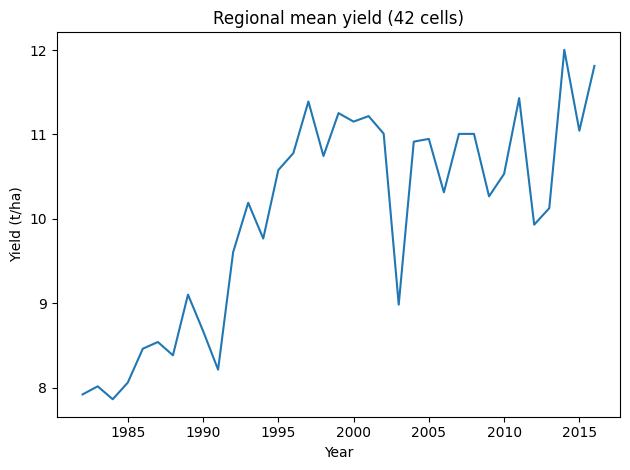

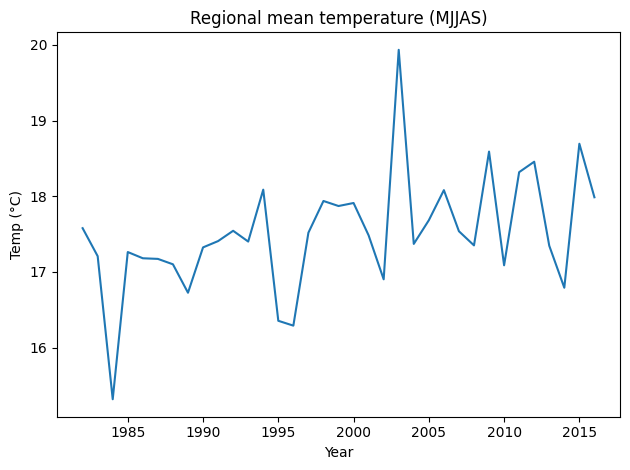

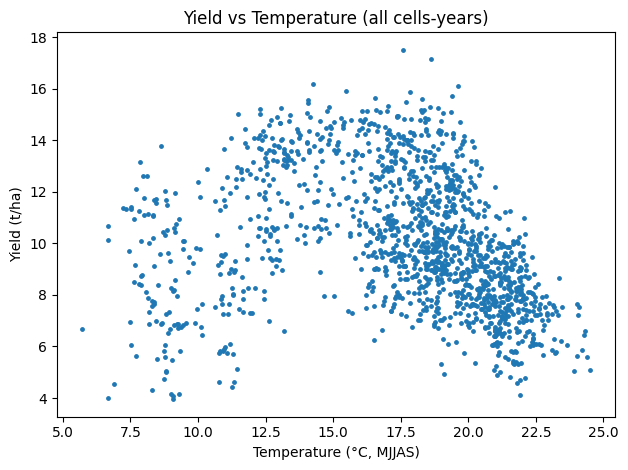

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json, time

# ===== paths =====
CORE_DIR = Path(r"..\italy_core_data")
DERIVED  = CORE_DIR / "derived"
IN_CSV   = DERIVED / "maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv"
MASK_CSV = DERIVED / "mask_core_42_on_gdhy.csv"
OUT_DIR  = DERIVED / "QA"
OUT_DIR.mkdir(exist_ok=True)

# (optional) plots
PLOT = True

# ===== load =====
df   = pd.read_csv(IN_CSV)
mask = pd.read_csv(MASK_CSV).sort_values(["lat","lon"]).reset_index(drop=True)
latc, lonc = mask["lat"].to_numpy(), mask["lon"].to_numpy()

# ===== basic structure checks =====
assert {"lat","lon","year"}.issubset(df.columns)
n_rows, n_cols = df.shape
uniq_cells = df[["lat","lon"]].drop_duplicates().shape[0]
uniq_years = df["year"].nunique()
dups = df.duplicated(["lat","lon","year"]).sum()
nans_total = int(df.isna().sum().sum())

print(f"Rows: {n_rows}  (expect 1470)")
print(f"Cols: {n_cols}")
print(f"Unique cells: {uniq_cells} (expect 42)")
print(f"Unique years: {uniq_years} (expect 35)")
print(f"Duplicate (lat,lon,year): {dups} (expect 0)")
print(f"Total NaNs: {nans_total} (expect 0)")

# fail-fast assertions
assert n_rows == 42*35, "Unexpected row count"
assert uniq_cells == 42, "Unexpected number of cells"
assert uniq_years == 35, "Unexpected number of years"
assert dups == 0, "Duplicate keys detected"
assert nans_total == 0, "Missing values found"

# ===== per-cell year coverage =====
coverage = (df.groupby(["lat","lon"])["year"]
              .agg(["count", "min", "max"])
              .rename(columns={"count":"years_present"}))
coverage.to_csv(OUT_DIR / "qa_cell_year_counts.csv")
assert (coverage["years_present"] == 35).all(), "Some cells are missing years"

# ===== variable organization =====
# identify seasonal columns (already present) and monthly columns (May..Sep)
month_suffixes = ["May","Jun","Jul","Aug","Sep"]
is_month_col = df.columns.str.contains("_(" + "|".join(month_suffixes) + ")$", regex=True)
monthly_cols = df.columns[is_month_col].tolist()

seasonal_cols = [
    "yield_maize","temperature","precipitation","soil_water","solar_radiation","potential_evaporation"
]
present_seasonal = [c for c in seasonal_cols if c in df.columns]

# ===== stats summary (per column) =====
def summarize(col):
    s = df[col]
    if pd.api.types.is_numeric_dtype(s):
        return {
            "count": int(s.count()),
            "min": float(s.min()),
            "p05": float(s.quantile(0.05)),
            "median": float(s.median()),
            "p95": float(s.quantile(0.95)),
            "max": float(s.max()),
        }
    else:
        return {"count": int(s.count()), "unique": int(s.nunique())}

summary = {}
for c in ["yield_maize","temperature","precipitation","soil_water","solar_radiation","potential_evaporation"]:
    if c in df.columns:
        summary[c] = summarize(c)

# add monthly summaries (group by variable base)
def base_name(c):
    for suf in month_suffixes:
        if c.endswith("_"+suf):
            return c[:-(len(suf)+1)]
    return None

monthly_groups = {}
for c in monthly_cols:
    b = base_name(c)
    monthly_groups.setdefault(b, []).append(c)

for b, cols in monthly_groups.items():
    cols_sorted = sorted(cols, key=lambda x: month_suffixes.index(x.split("_")[-1]))
    stats = {m: summarize(m) for m in cols_sorted}
    summary[b + "_monthly"] = stats

# write a flat CSV of simple stats for quick viewing
flat_rows = []
for k,v in summary.items():
    if isinstance(v, dict) and all(isinstance(vv, dict) for vv in v.values()):
        # monthly block
        for mon, sv in v.items():
            flat_rows.append({"variable": k, "component": mon, **sv})
    else:
        flat_rows.append({"variable": k, "component": "seasonal", **v})
pd.DataFrame(flat_rows).to_csv(OUT_DIR / "qa_summary.csv", index=False)

# ===== metadata (provenance) =====
meta = {
  "dataset_name": IN_CSV.name,
  "generated_at": time.strftime("%Y-%m-%d %H:%M:%S"),
  "rows": int(n_rows),
  "columns": int(n_cols),
  "keys": ["lat","lon","year"],
  "panel": {"cells": int(uniq_cells), "years": int(uniq_years), "balanced": True},
  "region": {
      "bbox": {
          "lat_min": float(latc.min()), "lat_max": float(latc.max()),
          "lon_min": float(lonc.min()), "lon_max": float(lonc.max())
      },
      "note": "Northern Italy (Po Valley); 42-core cells via geographic box ∩ 4-crop overlap; 1981 excluded."
  },
  "grid": {
    "resolution_deg": 0.5,
    "center_offset_deg": 0.25,
    "lon_convention": "0–360",
    "source": "GDHY maize grid"
  },
  "period": {"start_year": 1982, "end_year": 2016, "season": "MJJAS (May–September)"},
  "variables": {
    "yield_maize": {"unit": "t/ha", "type": "state", "aggregation": "annual"},
    "temperature": {"unit": "°C", "type": "state", "aggregation": "MJJAS mean"},
    "precipitation": {"unit": "mm", "type": "flux", "aggregation": "MJJAS total (daily mean × days per month)"},
    "soil_water": {"unit": "m³/m³", "type": "state", "aggregation": "MJJAS mean"},
    "solar_radiation": {"unit": "J/m²", "type": "flux", "aggregation": "MJJAS total (daily mean × days per month)"},
    "potential_evaporation": {"unit": "mm", "type": "flux", "aggregation": "MJJAS total (daily mean × days per month; sign flipped to +)"},
    "monthly_columns": {
        "months": month_suffixes,
        "temperature_*": {"unit": "°C", "aggregation": "monthly mean"},
        "precipitation_*": {"unit": "mm", "aggregation": "monthly total (daily mean × days per month)"},
        "soil_water_*": {"unit": "m³/m³", "aggregation": "monthly mean"},
        "solar_radiation_*": {"unit": "J/m²", "aggregation": "monthly total (daily mean × days per month)"},
        "potential_evaporation_*": {"unit": "mm", "aggregation": "monthly total (daily mean × days per month; sign flipped to +)"}
    }
  },
  "processing": {
    "era5_monthly_product": "Monthly averaged (daily means for fluxes)",
    "spatial_downsampling": "Block average 0.1° → 0.5° to GDHY centers (0.25° offset)",
    "temporal_aggregation": "MJJAS per rules above",
    "subset": "Exact 42 cells selected by value (nearest to centers); global crop to bbox before processing",
    "exclusions": "Year 1981 excluded; cells with incomplete years removed"
  },
  "inputs": {
    "seasonal_base_csv": str((DERIVED / "maize_ITnorth_core42_1982_2016_allstressors.csv").resolve()),
    "enriched_with_monthly_csv": str(IN_CSV.resolve()),
    "mask_core_42_csv": str(MASK_CSV.resolve())
  }
}
with open(OUT_DIR / "meta.json", "w") as f:
    json.dump(meta, f, indent=2)

# ===== optional quick plots =====
if PLOT:
    try:
        import matplotlib.pyplot as plt

        # regional means over time
        reg = (df.groupby("year")[["yield_maize","temperature","precipitation","potential_evaporation"]]
                 .mean().reset_index())

        plt.figure()
        plt.plot(reg["year"], reg["yield_maize"]); plt.xlabel("Year"); plt.ylabel("Yield (t/ha)")
        plt.title("Regional mean yield (42 cells)"); plt.tight_layout()
        plt.savefig(OUT_DIR / "fig_regional_yield_timeseries.png", dpi=120)

        plt.figure()
        plt.plot(reg["year"], reg["temperature"]); plt.xlabel("Year"); plt.ylabel("Temp (°C)")
        plt.title("Regional mean temperature (MJJAS)"); plt.tight_layout()
        plt.savefig(OUT_DIR / "fig_regional_temp_timeseries.png", dpi=120)

        # first scatter (for a sense-check)
        plt.figure()
        plt.scatter(df["temperature"], df["yield_maize"], s=6)
        plt.xlabel("Temperature (°C, MJJAS)"); plt.ylabel("Yield (t/ha)")
        plt.title("Yield vs Temperature (all cells-years)"); plt.tight_layout()
        plt.savefig(OUT_DIR / "fig_scatter_yield_vs_temp.png", dpi=120)

        print("Saved quick figures in:", OUT_DIR)
    except Exception as e:
        print("Plotting skipped:", e)

# ===== final message =====
print("\nQA complete.")
print("• Wrote:", OUT_DIR / "qa_summary.csv")
print("• Wrote:", OUT_DIR / "qa_cell_year_counts.csv")
print("• Wrote:", OUT_DIR / "meta.json")
